<a href="https://colab.research.google.com/github/mvsaraiva/seismic_erosion/blob/master/Autoencoder3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## 1) importar a sismica utilizanso o segyio
## 2) realizar controle de qualidade (clip, normalização, plot Il, Xl e time_slices)
## 3) realizar crop 2d ou 3D (pad ou cropar o dado nas dimensões multiplas do patch)
## 4) criar lista ou matriz com os dados de entrada e saida desejada
## 5) Input a dataset (no caso tensordataset funciona bem)
## 6) Create a dataloader (batch size, shuffle, transform, etc..)
## 7) Design a model (input, output, forward pass)
## 8) Define loss and opitimizer
## 9) Training loop (Forward, loss, backward, update weights)
## 10) make predictions using test data 
## 11) return the data (patchs) on to original format 

In [1]:
#Instalando as dependencias:
! pip install segyio

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import segyio
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Verificando a presença de GPU e setando o device:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
#importando a sismica
filename = '/content/drive/My Drive/F3_entire.segy'
seismic = segyio.tools.cube(filename)
IL, XL, twt =seismic.shape
print('n_IL:', IL, '| n_XL:', XL, '| n_amostras:', twt)


n_IL: 651 | n_XL: 951 | n_amostras: 462


In [5]:
def plot_seis(sismica):
  # clip = np.quantile(sismica,0.95)
  plt.figure(figsize=(10,5))
  sns.heatmap(sismica[250,:,:].T, cmap = 'gray_r') #, vmin=-clip, vmax=clip

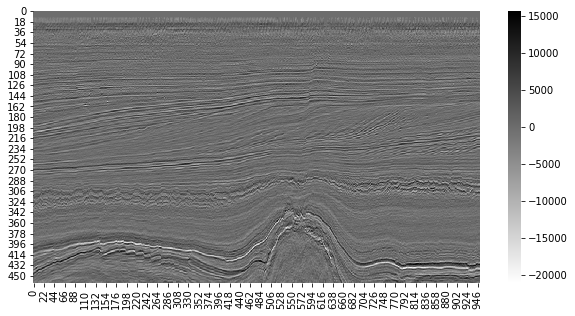

In [6]:
plot_seis(seismic)

In [7]:
#Clipa dado baseado no desvio padrão para retirada de outliers
def clipa_hist(volume,n_desv):
    
    desvio=volume.std()
    media=volume.mean()
    clipa=media+n_desv*desvio
    volume=np.clip(volume,-clipa,clipa) 
            
    return(volume)

In [8]:
seismic = clipa_hist(seismic,2)

In [9]:
def normaliza(volume,nome_volume):
    media_volume=volume.mean()
    max_volume=volume.max()
    min_volume=volume.min()
    volume_normalizado=(((volume-min_volume)/(max_volume-min_volume)))
    print('Média, máximo e mínimo antes da normalização: ' + nome_volume, volume.mean(), volume.max(), volume.min())
    print('Média, máximo e mínimo depois da normalização: '+ nome_volume, volume_normalizado.mean(), volume_normalizado.max(), volume_normalizado.min())
    np.savetxt(nome_volume+'.txt',[min_volume,max_volume,media_volume,volume_normalizado.min(),volume_normalizado.max(),volume_normalizado.mean()],header ='minimo, maximo e media antes e depois da normalizacao' )
    return volume_normalizado

In [10]:
seismic = normaliza(seismic, 'sismica')

Média, máximo e mínimo antes da normalização: sismica 7.842354 4887.9614 -4887.9614
Média, máximo e mínimo depois da normalização: sismica 0.50080067 1.0 0.0


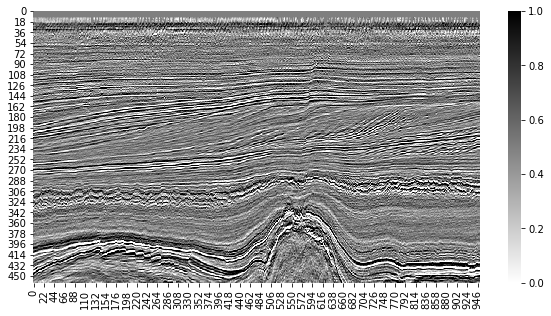

In [11]:
plot_seis(seismic)

In [13]:
# #Extrai subvolume sequenciais sem  sobreposição
# def patches3d_seq(y,size):
    
#     y_patches = y.unfold(2,size,size).unfold(1,size,size).unfold(0,size,size)
#     y_patches = y_patches.contiguous().view(-1,size,size,size)

#     return y_patches

In [12]:
seismic.shape

(651, 951, 462)

In [13]:
#Carrega a sismica como tensor:
seismic = torch.Tensor(seismic).unsqueeze(0)

In [14]:
print(seismic.shape)

torch.Size([1, 651, 951, 462])


In [17]:
# subvols = patches3d_seq(seismic,128)
# print(subvols.shape)

In [27]:
#Extrai patches 3D sem sobreposição
x = seismic  # batch, c, h, w
kc, kh, kw = 128, 128, 128  # kernel size
dc, dh, dw = 128, 128, 128  # stride

#padding
x = F.pad(x, (x.size(2)%dw // 2, x.size(2)%dw // 2,
              x.size(1)%dh // 2, x.size(1)%dh // 2,
              x.size(0)%dc // 2, x.size(0)%dc // 2))


patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(-1, patches.size(0), kc, kh, kw)
print(patches.shape)

#modificado de: https://discuss.pytorch.org/t/creating-nonoverlapping-patches-from-3d-data-and-reshape-them-back-to-the-image/51210/5

torch.Size([140, 1, 128, 128, 128])


In [19]:
# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())


tensor(True)


In [16]:
print(seismic.size())
x.size()

torch.Size([1, 651, 951, 462])


torch.Size([1, 651, 1041, 516])

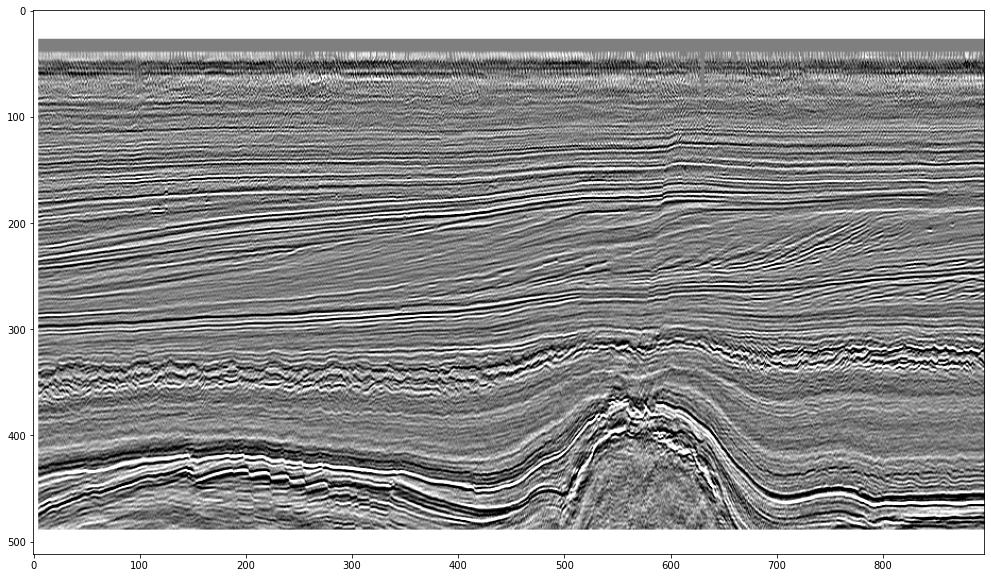

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(patches_orig[0,250,:,:].T, cmap= 'gray_r')

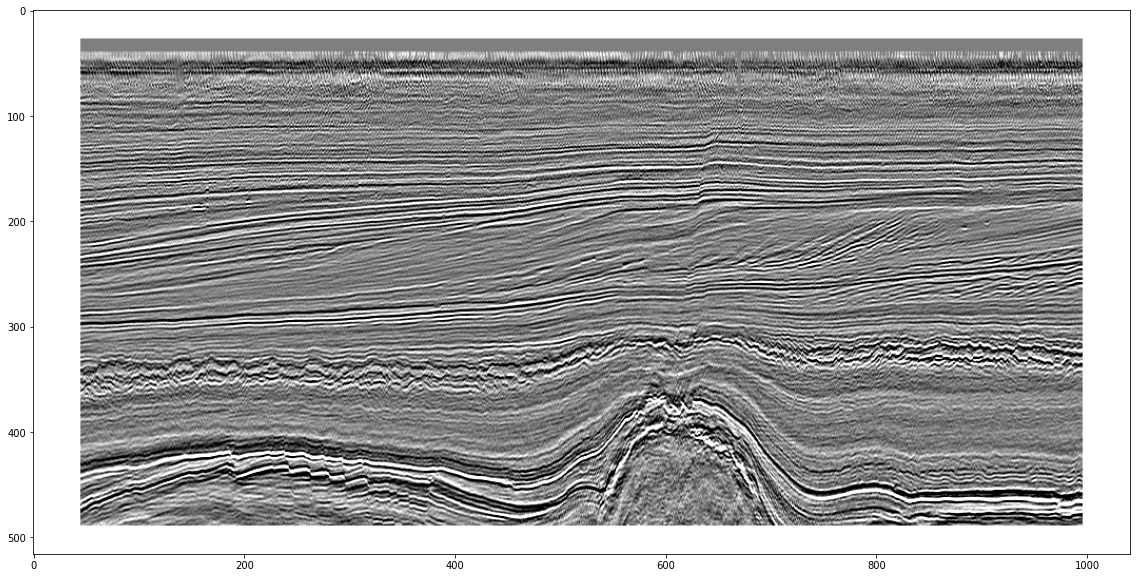

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(x[0,250,:,:].T, cmap= 'gray_r')

In [23]:
# subvols = subvols.unsqueeze(1)

In [18]:
print(patches.shape)

torch.Size([180, 1, 128, 128, 128])


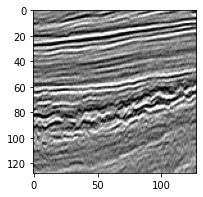

In [25]:
plt.figure(figsize=(3,3))
plt.imshow(patches[70,0,0,:,:].T, cmap = 'gray_r')

In [26]:
#train test split:
train = patches[0:120,:,:,:]
test = patches[120:-1,:,:,:]
print(train.shape, test.shape)

torch.Size([120, 1, 128, 128, 128]) torch.Size([19, 1, 128, 128, 128])


In [19]:
# train_dataset = torch.utils.data.TensorDataset(patches)
test_dataset = torch.utils.data.TensorDataset(patches)


In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, 4, False)
test_loader = torch.utils.data.DataLoader(test_dataset, 1, False)

In [21]:
dataiter = iter(train_loader)
sub = dataiter.next()

In [22]:
sub[0].shape

torch.Size([4, 1, 128, 128, 128])

In [23]:
# define the NN architecture
class Conv3DAutoencoder(nn.Module):
    def __init__(self):
        super(Conv3DAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv3d(1, 4,5, padding=2)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv2 = nn.Conv3d(4, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool3d(2,2)
        
        ## decoder layers ##
        self.conv4 = nn.Conv3d(8, 4, 5, padding=2)
        self.conv5 = nn.Conv3d(4, 1, 3, padding=1)
        

    def forward(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decoder 
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.sigmoid(self.conv5(x))
        
        return x

# initialize the NN
model = Conv3DAutoencoder().to(device)
print(model)

Conv3DAutoencoder(
  (conv1): Conv3d(1, 4, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv2): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(8, 4, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv5): Conv3d(4, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)


In [24]:
out = model(sub[0].to(device))

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [26]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = data[0]
        images= images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        outputs = outputs.to(device)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
torch.save(model,'model.pth')

Epoch: 1 	Training Loss: 0.210644
Epoch: 2 	Training Loss: 0.136273
Epoch: 3 	Training Loss: 0.121688
Epoch: 4 	Training Loss: 0.114023
Epoch: 5 	Training Loss: 0.108529
Epoch: 6 	Training Loss: 0.105223
Epoch: 7 	Training Loss: 0.103308
Epoch: 8 	Training Loss: 0.100808
Epoch: 9 	Training Loss: 0.099436
Epoch: 10 	Training Loss: 0.096283
Epoch: 11 	Training Loss: 0.094677
Epoch: 12 	Training Loss: 0.091674
Epoch: 13 	Training Loss: 0.090052
Epoch: 14 	Training Loss: 0.088703
Epoch: 15 	Training Loss: 0.087683
Epoch: 16 	Training Loss: 0.086482
Epoch: 17 	Training Loss: 0.085379
Epoch: 18 	Training Loss: 0.084479
Epoch: 19 	Training Loss: 0.084834
Epoch: 20 	Training Loss: 0.082305


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
torch.save(model,'model.pth')

In [ ]:
torch.load('/content/drive/My Drive/Colab Notebooks/model.pth')

In [1]:
output = torch.zeros_like(patches)
n=0
model.eval()
for data in test_loader:
  with torch.no_grad():
    
    images = data[0]
    images= images.to(device)
    output[n]= model(images)
    n=n+1



# output = output.detach()
# output = np.array(output.cpu())
# images = images.detach()
# images = np.array(images.cpu())


NameError: ignored

In [ ]:
print(output.shape)

In [ ]:
# Reshape back
patches_orig = output.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

# # Check for equality
# print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(patches_orig[0,250,:,:].T, cmap= 'gray_r')

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(x[0,250,:,:].T, cmap= 'gray_r')

In [ ]:
n=0
for i in range(5):
  n+=1
  print(n)